### Redes Neurais e Aprendizado Profundo
#### **MBA em Ciências de Dados**

### Módulo 5 - Redes neurais para dados sequenciais</span>

#### <span style="color:darkred">**Séries Multivariadas e Statefulness**</span>

Moacir Antonelli Ponti

---

Utilizaremos a base de dados 3W (Petrobrás) que possui séries multivariadas medidas em poços de petróleo

In [2]:
import numpy as np
from pandas import read_csv
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error
from math import sqrt

# outros
df1 = pd.read_csv("WELL-00001_20140124213136.csv")
df1.dropna(subset=['class'], inplace = True)

In [3]:
series = np.array(df1.iloc[:,2:6])

In [4]:
N = series.shape[0]
print("Tamanho da série: ", N)

Tamanho da série:  12440


## Parte 1: Preparando os dados

1. **Separação em treinamento e teste**: o treinamento sempre deve vir antes do teste no caso de dados sequenciais
2. **Normalização**: aqui utilizaremos a normalização Min-Max para 0-1
3. **Inserção de ruído opcional**: no treinamento e teste para avaliação da robustez dos modelos
4. **Formulação como aprendizado supervisionado**: adequando os arrays de forma a permitir uso nas redes neurais

In [5]:
# variaveis que definem divisao em treinamento e teste e controlam adição de ruído
porc_treinamento = 46
inserir_ruido_serie = False
inserir_ruido_teste = False
porc_ruido = 1

In [6]:
# calcula tamanhos dos dados de treinamento (n_train) e teste (n_test)
n_train = int(len(series)*(porc_treinamento/100.0))
n_test = len(series)-n_train+1

train_x = series[:n_train]
test_x = series[n_train-1:]

train_x_norm = np.zeros(train_x.shape)
test_x_norm = np.zeros(test_x.shape)

for i in range(series.shape[1]):
    vmin = train_x[:,i].min()
    vmax = train_x[:,i].max()
    train_x_norm[:,i] = (train_x[:,i] - vmin)/(vmax - vmin)
    test_x_norm[:,i] = (test_x[:,i] - vmin)/(vmax - vmin)

print("Exemplos de Treinamento: ", n_train)
print("Exemplos de Teste: ", n_test)

Exemplos de Treinamento:  5722
Exemplos de Teste:  6719


In [7]:
seed(1)
set_seed(1)

# insere ruido na serie
if (inserir_ruido_serie):
    train_x_norm = train_x_norm + np.random.randn(n_train)*(porc_ruido/100.0)

# insere ruido apenas no teste
if (inserir_ruido_teste):
    test_x_norm = test_x_norm + np.random.randn(n_test)*(porc_ruido/100.0)

## Parte 2: problema regressão com entrada multivariada

Vamos usar as séries 1, 2 e 3 para prever a série 0.

In [8]:
train_y_norm = np.array(train_x_norm[:,0], copy=True)
test_y_norm = np.array(test_x_norm[:,0], copy=True)

train_x_norm = np.delete(train_x_norm, 0, 1)
test_x_norm = np.delete(test_x_norm, 0, 1)

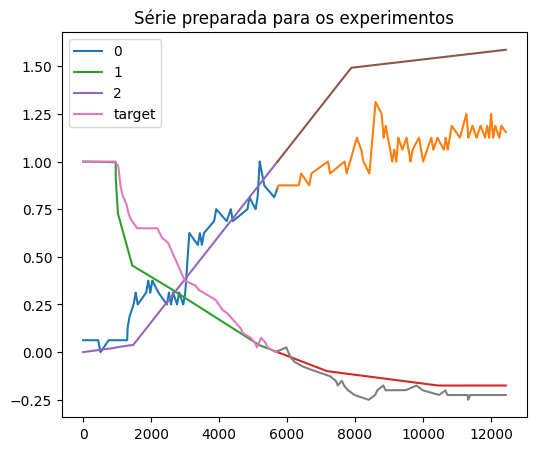

In [9]:
plt.figure(figsize=(6,5))
for i in range(train_x_norm.shape[1]):
    plt.plot(np.arange(0, n_train), train_x_norm[:,i], label=str(i))
    plt.plot(np.arange(n_train,n_train+n_test), test_x_norm[:,i])

plt.plot(np.arange(0, n_train), train_y_norm, label='target')
plt.plot(np.arange(n_train,n_train+n_test), test_y_norm)
ax = plt.title('Série preparada para os experimentos')
plt.legend()

In [10]:
test_x_norm[:4]

array([[ 8.61920000e-01,  0.00000000e+00,  1.00000000e+00],
       [ 8.62560000e-01, -6.88846986e-05,  1.00022317e+00],
       [ 8.63040000e-01, -1.37769397e-04,  1.00045055e+00],
       [ 8.63520000e-01, -2.05824160e-04,  1.00067793e+00]])

In [11]:
test_y_norm[:4]

array([0.00443615, 0.00452387, 0.00459906, 0.00468678])

In [12]:
# formato deve ser [samples, time steps, features]
def recurrent_array(data, target, time_steps=1):

    array_in = np.array(np.reshape(data, (-1, data.shape[1])), copy=True)
    array_out= np.array(np.reshape(target, (-1, 1)), copy=True)

    train_y_ts = array_out[time_steps:]
    train_x_ts = []
    for i in range(0, len(array_in) - time_steps):
        train_x_ts.append(array_in[i:i+time_steps])

    train_x_ts = np.array(train_x_ts)

    #rec_array = np.reshape(array, (array.shape[0], time_steps, array.shape[1]))
    return train_x_ts, train_y_ts

In [13]:
time_steps = 2

train_x_rec, train_y_rec = recurrent_array(train_x_norm, train_y_norm, time_steps=time_steps)
test_x_rec, test_y_rec = recurrent_array(test_x_norm, test_y_norm, time_steps=time_steps)

In [14]:
print('Dados de treinamento para rede recorrente')
print('Tamanho dos arrays de teste x e y')
print(train_x_rec.shape)
print(train_y_rec.shape)

print('\nPrimeiros 5 elementos de teste x e y')
print(test_x_rec[:5])
print(test_y_rec[:5])

no_features = train_x_rec.shape[2]
print('\nNúmero de features:', no_features)

Dados de treinamento para rede recorrente
Tamanho dos arrays de teste x e y
(5720, 2, 3)
(5720, 1)

Primeiros 5 elementos de teste x e y
[[[ 8.61920000e-01  0.00000000e+00  1.00000000e+00]
  [ 8.62560000e-01 -6.88846986e-05  1.00022317e+00]]

 [[ 8.62560000e-01 -6.88846986e-05  1.00022317e+00]
  [ 8.63040000e-01 -1.37769397e-04  1.00045055e+00]]

 [[ 8.63040000e-01 -1.37769397e-04  1.00045055e+00]
  [ 8.63520000e-01 -2.05824160e-04  1.00067793e+00]]

 [[ 8.63520000e-01 -2.05824160e-04  1.00067793e+00]
  [ 8.64000000e-01 -2.74708858e-04  1.00090531e+00]]

 [[ 8.64000000e-01 -2.74708858e-04  1.00090531e+00]
  [ 8.64640000e-01 -3.43593557e-04  1.00112848e+00]]]
[[0.00459906]
 [0.00468678]
 [0.00476196]
 [0.00484968]
 [0.00492487]]

Número de features: 3


## Statefullness

Ao considerar uma unidade recorrente como "*stateful*" estamos indicando que cada seleção de batch é a continuação da anterior.

Isso só é possível se usarmos batches sequenciais e sem embaralhamento (shuffle) por isso a recomendação anterior de usar batchsize 1 para predição do próximo instante de tempo.

O *stateful* também permite que a LSTM mantenha a memória mesmo quando usamos time_step=1, desde que os batches sejam sequenciais, de forma que cada posição do batch na iteração $j$ é uma continuação da mesma posição do batch $j-1$

Além disso:
* é preciso especificar na própria arquitetura o batch size
* o **batch_size tem que ser divisível** pelo total de exemplos de treinamento para não haver sobras no final da época
* **LayerNormalization** passa a ser necessário para evitar problemas com a magnitude do gradiente. Ao retirá-lo obtemos `nan` como valor de custo após algumas épocas

In [39]:
# decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch >= 2):
        lr = float(lr * tf.math.exp(-0.025))
    print(f"{epoch+1} - learning rate {lr:.7f}")
    return lr

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [40]:
# checando batch size
print(train_x_rec.shape[0])
batch_size = 10
print(train_x_rec.shape[0]/batch_size)

5720
572.0


In [41]:
def model_LSTM_stateful(input_shape, batch_size=1, stateful=True,
                        hidden_units=16, do_rate=0.25):

    x = layers.Input(shape=input_shape, batch_size=batch_size)

    lstm_1 = layers.LSTM(hidden_units, return_sequences=True,
                         activation='tanh', stateful=stateful)(x)
    lstm_1 = layers.LSTM(hidden_units,
                         activation='tanh', stateful=stateful)(lstm_1)
    feats = layers.LayerNormalization()(lstm_1)

    drop = layers.Dropout(do_rate)(feats)
    outputs = layers.Dense(1, trainable=True, activation='linear')(drop)
    model = tf.keras.models.Model(x, outputs)

    # retornar lstm layers para poder processá-los
    lstm_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.LSTM)]

    return model, lstm_layers

In [42]:
modelStat, _ = model_LSTM_stateful(input_shape=(train_x_rec.shape[1], train_x_rec.shape[2]),
                                batch_size=batch_size, do_rate=0.25)
modelStat.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (10, 2, 3)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (10, 2, 16)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (10, 16)                    │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_9                │ (10, 16)                    │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (10, 16)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (10, 1)                     │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,441 (13.44 KB)

 Trainable params: 3,441 (13.44 KB)

 Non-trainable params: 0 (0.00 B)

Nesse tipo de modelo, é mais indicado resetar os estados das unidades LSTM a cada época.
- caso queiramos fazer decrescer o learning rate, então também é preciso re-compilar o modelo com o valor a cada época

In [43]:
epochs = 8
no_features = 3

seed(1)
set_seed(1)

modelStat, layersLSTM = model_LSTM_stateful(input_shape=(train_x_rec.shape[1], train_x_rec.shape[2]),
                                            batch_size=batch_size, do_rate=0.25)

# compilacao e treinamento
lr = float(0.0001)

hist_all = []
for i in range(epochs):
    lr = scheduler(i, lr)
    modelStat.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.AdamW(learning_rate=lr),
            metrics=['mae'])
    hist = modelStat.fit(train_x_rec, train_y_rec,
                  batch_size=batch_size, epochs=1,
                  shuffle=False,
                  verbose=1)

    # Reset states of all LSTM layers after each epoch
    for layer_r in layersLSTM:
        layer_r.reset_states()

    hist_all.append(hist.history['loss'])

1 - learning rate 0.0001000
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4284 - mae: 0.5022
2 - learning rate 0.0001000
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2489 - mae: 0.3639
3 - learning rate 0.0000980
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1171 - mae: 0.2545
4 - learning rate 0.0000961
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0794 - mae: 0.2035
5 - learning rate 0.0000942
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0467 - mae: 0.1564
6 - learning rate 0.0000923
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0308 - mae: 0.1282
7 - learning rate 0.0000905
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0276 - mae: 0.1211
8 - learning rate 0.0000887
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0239 - mae: 0.1143


In [44]:
scores = modelStat.evaluate(train_x_rec, train_y_rec, batch_size=batch_size, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

Scores treinamento
MSE: 0.0113
MAE: 0.0793


In [45]:
# ERRO - batchsize foi fixado no modelo e ao tentar usar o padrao, falhará
#scoresT = modelStat.evaluate(test_x_rec, test_y_rec, verbose=0)
#print('Scores test')
#print('MSE: %.4f' % (scoresT[0]))
#print('MAE: %.4f' % (scoresT[1]))

Como o modelo foi criado com batch_size fixo e relacionado ao conjunto de treinamento, depois não conseguimos usá-lo para outras inferências e testes

Assim é preciso criar um novo modelo com batch_size=1 e setar os pesos do modelo treinado

In [48]:
new_batch_size = 1

inference_model, _ = model_LSTM_stateful(input_shape=(train_x_rec.shape[1], train_x_rec.shape[2]),
                                      batch_size=new_batch_size, do_rate=0.25)

inference_model.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
            metrics=['mae'])

# copia pesos do modelo anterior
pesos_modelo = modelStat.get_weights()
inference_model.set_weights(pesos_modelo)

In [49]:
scoresT = inference_model.evaluate(test_x_rec, test_y_rec,
                                   batch_size=new_batch_size, verbose=0)
print('Scores test')
print('MSE: %.4f' % (scoresT[0]))
print('MAE: %.4f' % (scoresT[1]))

Scores test
MSE: 0.0005
MAE: 0.0123


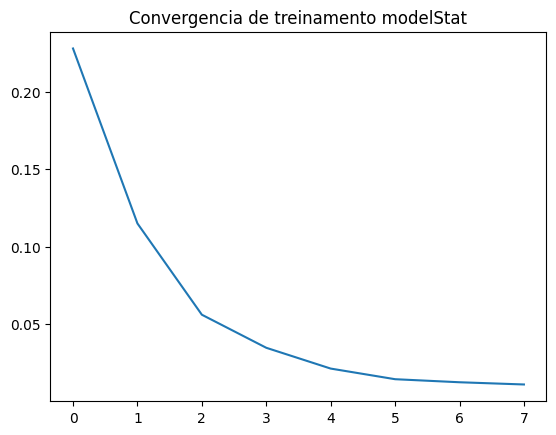

In [51]:
plt.plot(hist_all)
ax = plt.title('Convergencia de treinamento modelStat')

In [52]:
# realiza predicoes com os dados de treinamento e teste
train_y_predS = inference_model.predict(train_x_rec, batch_size=new_batch_size)
train_y_predS = np.reshape(train_y_predS, (-1, 1))[time_steps:]

test_y_predS = inference_model.predict(test_x_rec, batch_size=new_batch_size)
test_y_predS = np.reshape(test_y_predS, (-1, 1))[time_steps:]

5720/5720 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6717/6717 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


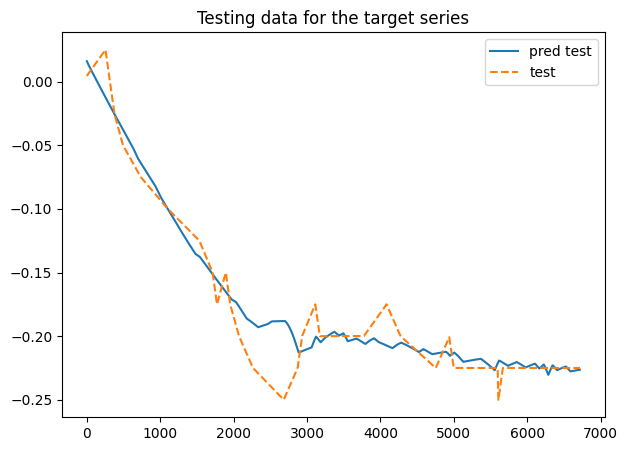

In [53]:
fig = plt.figure(figsize=(7,5))
plt.plot(np.arange(time_steps,len(test_y_predS)+time_steps),
         test_y_predS, label='pred test')
plt.plot(test_y_norm, '--', label='test')
plt.legend()
axt = plt.title('Testing data for the target series')
plt.show()

In [56]:
seed(1)
set_seed(1)

modelL, _ = model_LSTM_stateful(input_shape=(train_x_rec.shape[1], train_x_rec.shape[2]),
                             batch_size=batch_size, stateful=False,  do_rate=0.25)
epochs = 8
no_features = 3

# compilacao e treinamento
lr = 0.0001

modelL.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.AdamW(learning_rate=lr),
            metrics=['mae'])
hist_all2 = modelL.fit(train_x_rec, train_y_rec,
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr],
                  shuffle=False,
                  verbose=1)

1 - learning rate 0.0001000
Epoch 1/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3028 - mae: 0.3995 - learning_rate: 1.0000e-04
2 - learning rate 0.0001000
Epoch 2/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0772 - mae: 0.2024 - learning_rate: 1.0000e-04
3 - learning rate 0.0000980
Epoch 3/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0434 - mae: 0.1563 - learning_rate: 9.8020e-05
4 - learning rate 0.0000961
Epoch 4/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0338 - mae: 0.1356 - learning_rate: 9.6079e-05
5 - learning rate 0.0000942
Epoch 5/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0271 - mae: 0.1234 - learning_rate: 9.4176e-05
6 - learning rate 0.0000923
Epoch 6/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0212 - mae: 0.1102 - learning_rate: 9.2312e-05
7 - learning rate 0.0000905
Epoch 7/8
572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0199 - mae: 0.1073 - learning_rate: 9.0484e-05
8 - learning rate 0.0000887
Epoch 8/8
572/572 ━━

In [57]:
scores2 = modelL.evaluate(train_x_rec, train_y_rec, batch_size=batch_size, verbose=0)
scoresT2 = modelL.evaluate(test_x_rec, test_y_rec,
                                   batch_size=batch_size, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores2[0]))
print('MAE: %.4f' % (scores2[1]))

print('Scores test')
print('MSE: %.4f' % (scoresT2[0]))
print('MAE: %.4f' % (scoresT2[1]))

Scores treinamento
MSE: 0.0104
MAE: 0.0780
Scores test
MSE: 0.0009
MAE: 0.0252


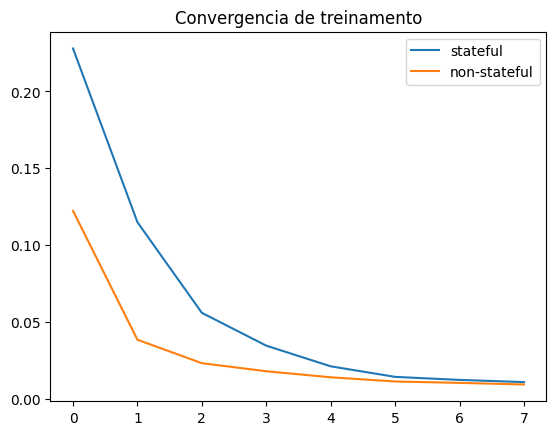

In [58]:
plt.plot(hist_all, label='stateful')
plt.plot(hist_all2.history['loss'], label='non-stateful')
plt.legend()
ax = plt.title('Convergencia de treinamento')

In [59]:
# realiza predicoes com os dados de treinamento e teste
train_y_predL = modelL.predict(train_x_rec, batch_size=batch_size)
train_y_predL = np.reshape(train_y_predL, (-1, 1))[time_steps:]

test_y_predL = modelL.predict(test_x_rec, batch_size=batch_size)
test_y_predL = np.reshape(test_y_predL, (-1, 1))[time_steps:]

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
672/672 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


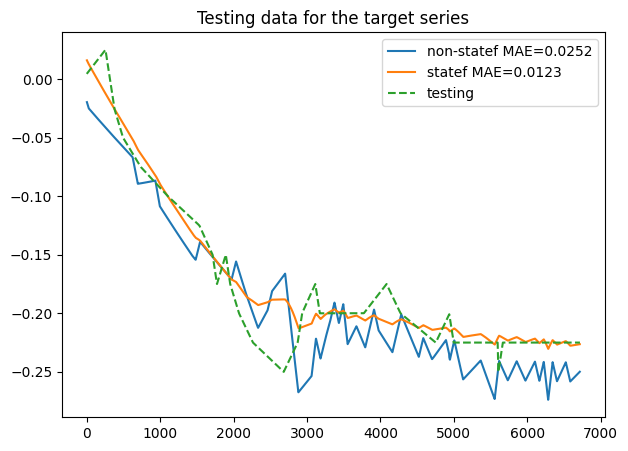

In [60]:
fig = plt.figure(figsize=(7,5))
plt.plot(np.arange(time_steps,len(test_y_predL)+time_steps),
         test_y_predL, label=f'non-statef MAE={scoresT2[1]:.4f}')
plt.plot(np.arange(time_steps,len(test_y_predS)+time_steps),
         test_y_predS, label=f'statef MAE={scoresT[1]:.4f}')
plt.plot(test_y_norm, '--', label='testing')
plt.legend()
axt = plt.title('Testing data for the target series')
plt.show()